In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.cm as cm

In [ ]:
# Loading data
inputFeature = pd.read_csv('../../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [3]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Normalizing numerical features
for feature in numerical_features:
  train[feature] = (train[feature] - train[feature].min()) / (train[feature].max() - train[feature].min())
  test[feature] = (test[feature] - test[feature].min()) / (test[feature].max() - test[feature].min())

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [4]:
# Dataset for tabular data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [6]:
# Model
class AutoEncoder(nn.Module):
  def __init__(self, input_size, hidden_layers, out_act, **kwargs):
    super().__init__()
    # Layers
    self.layers  = nn.ModuleList()
    self.out_act = out_act
    self.out_params = kwargs
    # Encoder
    # Creating first layer
    self.num_encoding_layers = 0
    self.layers.append(nn.Linear(input_size, hidden_layers[0]))
    self.num_encoding_layers += 1
    self.layers.append(nn.BatchNorm1d(hidden_layers[0]))
    self.num_encoding_layers += 1
    # Creating other encoder layers specified in hidden_layers
    for i in range(1, len(hidden_layers)):
        self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.num_encoding_layers += 1
        self.layers.append(nn.BatchNorm1d(hidden_layers[i]))
        self.num_encoding_layers += 1
      
    # Decoder
    self.num_decoding_layers = 0
    for i in reversed(range(1, len(hidden_layers))):
        self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i-1]))
        self.num_decoding_layers += 1
        self.layers.append(nn.BatchNorm1d(hidden_layers[i-1]))
        self.num_decoding_layers += 1
    self.layers.append(nn.Linear(hidden_layers[0], input_size))
    self.num_decoding_layers += 1

  # Encoding
  def encode(self, x):
    for i in range(1, self.num_encoding_layers, 2):
        #print(self.layers[i-1])
        x = self.layers[i-1](x)
        #print(self.layers[i])
        x = self.layers[i](x)
        x = F.relu(x)
    return x

  # Decoding
  def decode(self, x):
    for i in range(1, self.num_decoding_layers-1, 2):
        #print(self.layers[i + self.num_encoding_layers - 1])
        x = self.layers[i + self.num_encoding_layers - 1](x)
        #print(self.layers[i + self.num_encoding_layers])
        x = self.layers[i + self.num_encoding_layers](x)
        x = F.relu(x)
    x = self.layers[-1](x)
    if self.out_act != 'mixed':
        return self.out_act(x)
    else:
        x_num = self.out_params['num_act'](x[:, :self.out_params['num_features']])
        x_cat = self.out_params['cat_act'](x[:, self.out_params['num_features']:])
        x = torch.cat((x_num, x_cat), dim=1)
        return x
    
  def forward(self, x):
    enc = self.encode(x)
    dec = self.decode(enc)
    return dec

In [7]:
model = AutoEncoder(227, [128, 64, 32], out_act=F.sigmoid)
print(model)

AutoEncoder(
  (layers): ModuleList(
    (0): Linear(in_features=227, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=128, out_features=227, bias=True)
  )
)


In [9]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(227, [128, 64, 32, 16], out_act=F.sigmoid).to(device)
criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
print_every = 40
steps = 0
train_losses, test_losses = [], []
test_loss_min = np.Inf

for e in range(epochs):
  running_loss = 0
  running_loss_ = 0
  for X, y in trainloader:
    steps += 1
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss1 = criterion1(output[:, :8], y[:, :8])
    loss2 = criterion2(output[:, 8:], y[:, 8:])
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    running_loss_ += loss.item()

    if steps % print_every == 0:
      print(f'Epoch {e+1}/{epochs}, Step {steps}, Train Loss: {running_loss_/print_every:.3f}')
      running_loss_ = 0



  else:
    running_testloss = 0
    with torch.no_grad():
      model.eval()
      for X, y in testloader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss1 = criterion1(output[:, :8], y[:, :8])
        loss2 = criterion2(output[:, 8:], y[:, 8:])
        loss = loss1 + loss2
        running_testloss += loss.item()
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(running_testloss/len(testloader))
    if test_losses[-1] <= test_loss_min:
        print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_losses[-1]))
        torch.save(model.state_dict(), 'model.pt')
    print(f'Epoch {e+1}/{epochs}, Train Loss: {running_loss/len(trainloader):.3f}, Test Loss: {running_testloss/len(testloader):.3f}')
    

Epoch 1/20, Step 40, Train Loss: 0.484
Epoch 1/20, Step 80, Train Loss: 0.199
Epoch 1/20, Step 120, Train Loss: 0.143
Epoch 1/20, Step 160, Train Loss: 0.122
Epoch 1/20, Step 200, Train Loss: 0.110
Epoch 1/20, Step 240, Train Loss: 0.104
Epoch 1/20, Step 280, Train Loss: 0.098
Epoch 1/20, Step 320, Train Loss: 0.094
Epoch 1/20, Step 360, Train Loss: 0.092
Epoch 1/20, Step 400, Train Loss: 0.090
Epoch 1/20, Step 440, Train Loss: 0.087
Epoch 1/20, Step 480, Train Loss: 0.087
Test loss decreased (inf --> 0.082489).  Saving model ...
Epoch 1/20, Train Loss: 0.143, Test Loss: 0.082
Epoch 2/20, Step 520, Train Loss: 0.084
Epoch 2/20, Step 560, Train Loss: 0.083
Epoch 2/20, Step 600, Train Loss: 0.080
Epoch 2/20, Step 640, Train Loss: 0.081
Epoch 2/20, Step 680, Train Loss: 0.080
Epoch 2/20, Step 720, Train Loss: 0.077
Epoch 2/20, Step 760, Train Loss: 0.077
Epoch 2/20, Step 800, Train Loss: 0.077
Epoch 2/20, Step 840, Train Loss: 0.076
Epoch 2/20, Step 880, Train Loss: 0.075
Epoch 2/20, Step

In [10]:
# Creating a new dataset that contains all the data ordered by their indices
all_data = pd.concat([train, test], axis=0).sort_index()
X = torch.nan_to_num(torch.Tensor(all_data.values.astype('float32')))
y = torch.nan_to_num(torch.Tensor(all_data.values.astype('float32')))
dataset = MyDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Creating a latent space on the dataset
with torch.no_grad():
    model.eval()
    full_latent_space = []
    for X, _ in tqdm(dataloader):
        latent_space = model.encode(X.to(device))
        full_latent_space.append(latent_space)

latent_space = torch.cat(full_latent_space, dim=0)
latent_space = latent_space.to('cpu').numpy()
latent_space.shape

100%|███████████████████████████████████████████████████████████████████████████████| 534/534 [00:00<00:00, 618.21it/s]


(17058, 16)

In [11]:
# Dimension reduction to 2 with PCA if neccesary
if latent_space.shape[1] != 2:
    pca_2var = PCA(n_components=2)
    latent_space_2var = pca_2var.fit_transform(latent_space)

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_10448\2984411298.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', optimal_k)


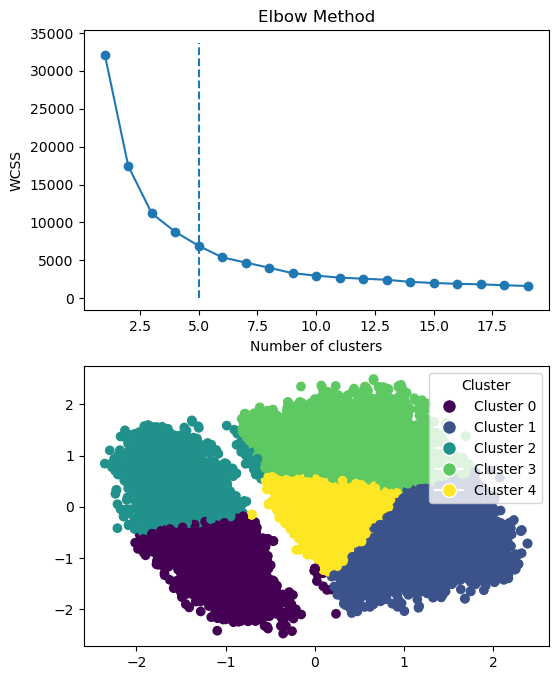

In [12]:
# Function to calculate WCSS
def calculate_wcss(X, max_clusters):
    wcss = []
    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    return wcss

# Calculate WCSS for different values of k
wcss = calculate_wcss(latent_space_2var, 20)

# Use KneeLocator to find the elbow point
kneedle = KneeLocator(range(1, 20), wcss, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Kmeans with the optimal number of clusters
kmeans_actual = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_actual.fit(latent_space_2var)

# Colormap for clustering
cmap = cm.get_cmap('viridis', optimal_k)

f, ax = plt.subplots(2, 1, figsize=(6, 8))
# Plot the Elbow Method graph
ax[0].plot(range(1, 20), wcss, marker='o')
ax[0].vlines(optimal_k, ax[0].get_ylim()[0], ax[0].get_ylim()[1], linestyles='dashed')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('WCSS')
ax[1].scatter(latent_space_2var[:, 0], latent_space_2var[:, 1], c=kmeans_actual.labels_, cmap=cmap)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(optimal_k)]
labels = [f'Cluster {cluster}' for cluster in range(optimal_k)]
ax[1].legend(handles, labels, title='Cluster')
plt.show()
